In [494]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from statsmodels.tsa.tsatools import detrend
import statsmodels.formula.api as sm
import itertools
import sys
import datetime
# sns.set()
idx = pd.IndexSlice

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [4]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

## Load national index and percent gen data

In [5]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data', 'National index.csv')
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [6]:
national_index.head()

,year,month,generation (mwh),final co2 (kg),datetime,quarter,index (g/kwh),change since 2005,index (lb/mwh),nerc
0,2001,1,332493160.0,2.149920e+11,2001-01-01,1,646.604591,0.076326,1425.504481,USA
1,2001,2,282940198.0,1.803140e+11,2001-02-01,1,637.284923,0.060812,1404.958340,USA
2,2001,3,300706544.0,1.891340e+11,2001-03-01,1,628.965732,0.046964,1386.617853,USA
3,2001,4,278078871.0,1.748850e+11,2001-04-01,2,628.902838,0.046860,1386.479197,USA
4,2001,5,300491621.0,1.892470e+11,2001-05-01,2,629.790069,0.048337,1388.435187,USA


In [7]:
path = join(cwd, '..', 'Data storage', 'National data', 'National percent gen.csv')
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'

In [8]:
national_per_gen.head()

,year,month,fuel category,generation (mwh),datetime,nerc
0,2001,1,Coal,0.533205,2001-01-01,USA
1,2001,2,Coal,0.529212,2001-02-01,USA
2,2001,3,Coal,0.516347,2001-03-01,USA
3,2001,4,Coal,0.505866,2001-04-01,USA
4,2001,5,Coal,0.504483,2001-05-01,USA


In [9]:
path = join(cwd, '..', 'Data storage', 'National data', 'National generation.csv')
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [10]:
national_gen.head()

,fuel category,year,month,generation (mwh),datetime,nerc
0,Coal,2001,1,177287111.0,2001-01-01,USA
1,Coal,2001,2,149735484.0,2001-02-01,USA
2,Coal,2001,3,155269011.0,2001-03-01,USA
3,Coal,2001,4,140670654.0,2001-04-01,USA
4,Coal,2001,5,151592914.0,2001-05-01,USA


## Load NERC index and percent gen data

In [11]:
path = join(cwd, '..', 'Data storage', 'final NERC data', 'NERC gen emissions and index.csv')
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

In [12]:
nerc_index.head()

,nerc,year,month,final co2 (kg),generation (mwh),index (g/kwh),datetime
0,-,2001,1,5.476076e+09,7185661.388,762.083771,2001-01-01
1,-,2001,2,4.349473e+09,6526739.453,666.408193,2001-02-01
2,-,2001,3,4.223575e+09,6304139.884,669.968545,2001-03-01
3,-,2001,4,4.544873e+09,6624660.323,686.053817,2001-04-01
4,-,2001,5,4.972656e+09,7045482.729,705.793523,2001-05-01


In [13]:
path = join(cwd, '..', 'Data storage', 'final NERC data', 'NERC percent gen.csv')
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])
nerc_per_gen.drop(['year', 'month'], inplace=True, axis=1)

In [14]:
nerc_per_gen.head()

,fuel category,datetime,nerc,generation (mwh)
0,Coal,2001-01-01,-,0.693624
1,Coal,2001-02-01,-,0.616249
2,Coal,2001-03-01,-,0.601500
3,Coal,2001-04-01,-,0.621707
4,Coal,2001-05-01,-,0.637201


## Combine NERC and national results

In [159]:
index = pd.concat([national_index, nerc_index])

In [160]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [17]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])
per_gen.rename(columns={'generation (mwh)': 'Fraction Generation'}, inplace=True)
per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [18]:
per_gen.head()

,datetime,fuel category,Fraction Generation,month,nerc,year
0,2001-01-01,Coal,0.533205,1,USA,2001
1,2001-02-01,Coal,0.529212,2,USA,2001
2,2001-03-01,Coal,0.516347,3,USA,2001
3,2001-04-01,Coal,0.505866,4,USA,2001
4,2001-05-01,Coal,0.504483,5,USA,2001


## Figures

In [19]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

In [20]:
def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, ax_labels=None,
                      FG_kwargs={}, plot_kwargs={}, context='notebook',
                      font_scale=1.2):
    sns.set_context(context, font_scale)
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if ax_labels:
        g.set_axis_labels(ax_labels)

### Index figure

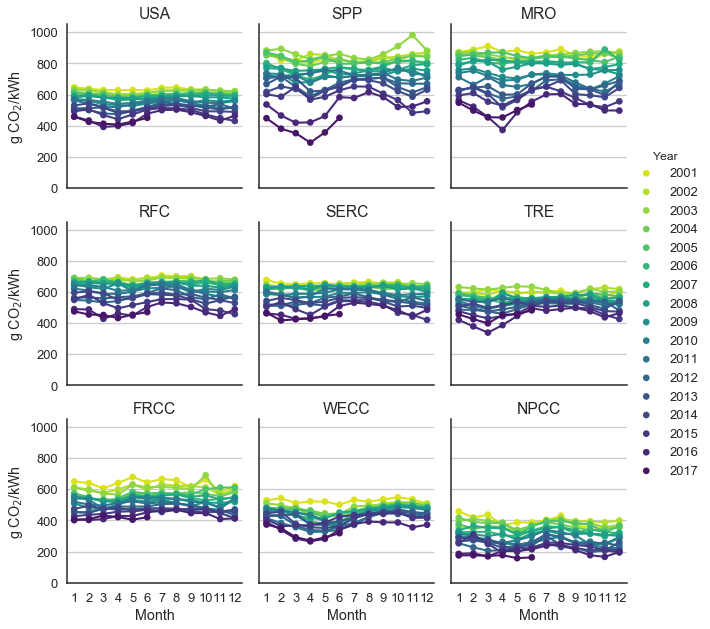

In [276]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')
# plt.savefig(path, bbox_inches='tight')

#### Alternate plot of CO₂ intensity

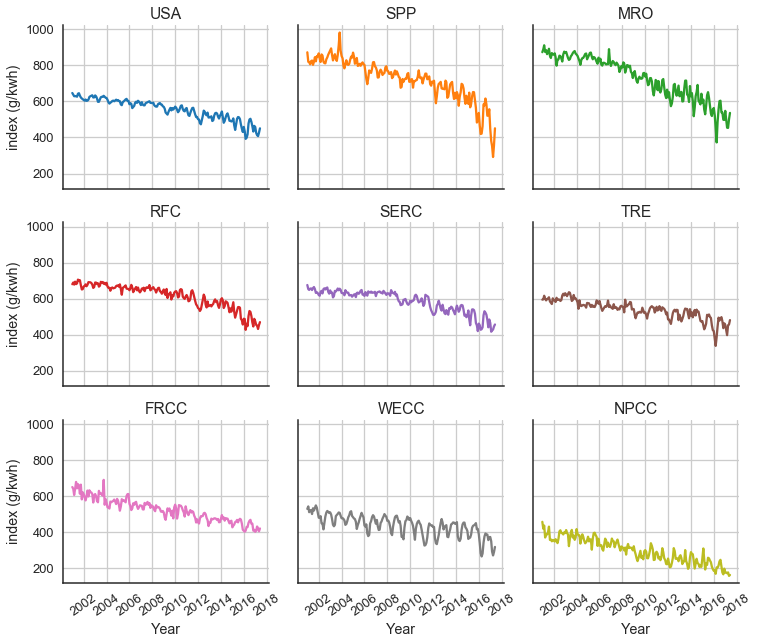

In [572]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity, using a linear detrend

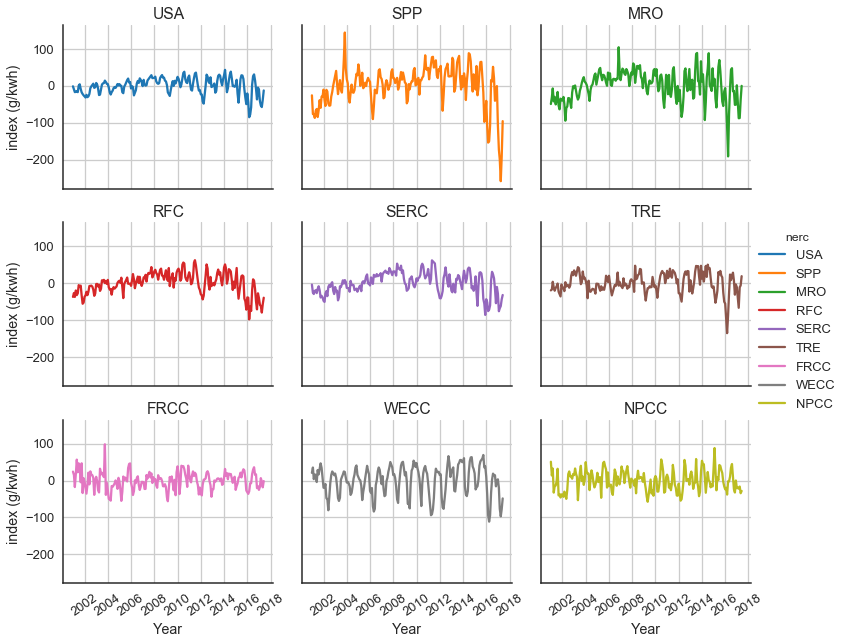

In [164]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend

In [170]:
def diff_detrend(series, n=1):
    d = series - series.shift(n)
    return d

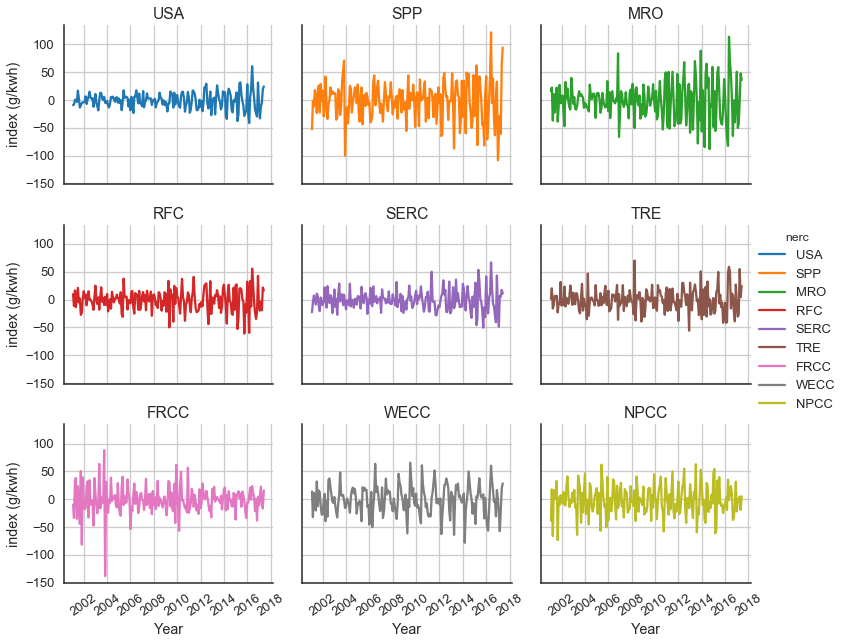

In [172]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

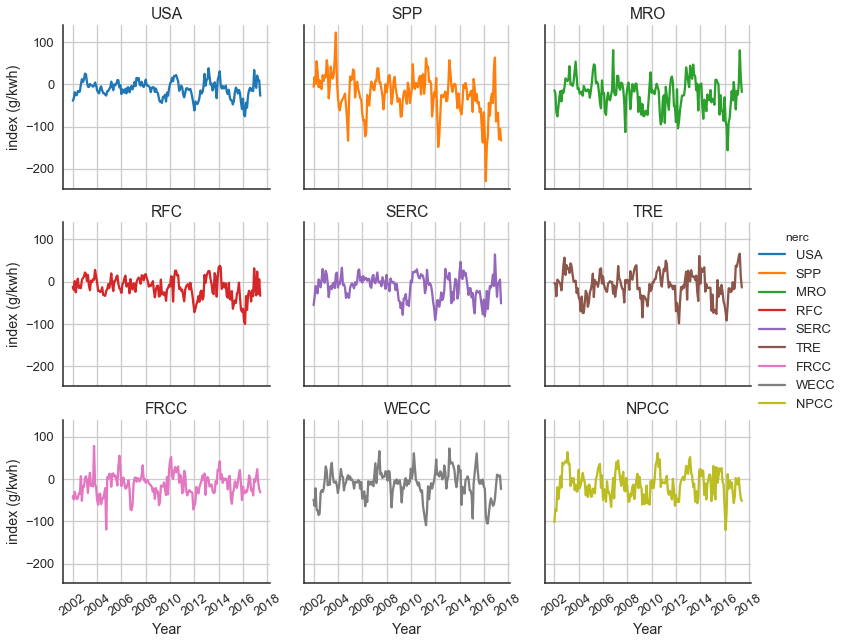

In [184]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'], 12)


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend

In [187]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [262]:
def annual_detrend(df):
    data = df.copy()
    data.reset_index(inplace=True)
    years = data['year'].unique()
#     data.set_index(['year'], inplace=True)
    
    
    for year in years:
        
        d_ = detrend(data.loc[data['year'] == year, 'index (g/kwh)'])
        data.loc[data['year'] == year, 'index (g/kwh)'] = d_
    
#     data.set_index('nerc', inplace=True)
    return data.loc[:, 'index (g/kwh)']

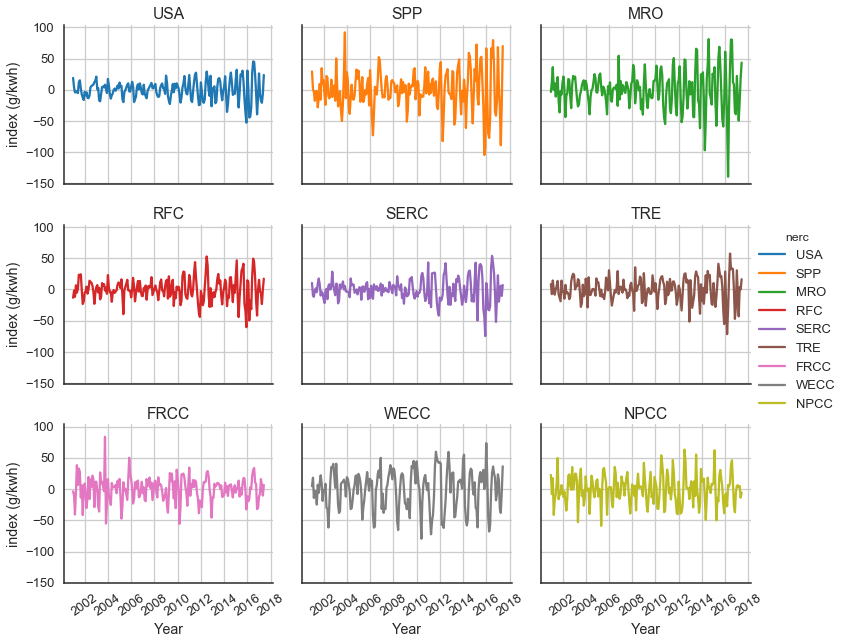

In [256]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index('nerc', inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[nerc, 'index (g/kwh)'] = annual_detrend(detrend_index.loc[nerc])

detrend_index.set_index('datetime', append=True, inplace=True)
detrend_index.sort_index(level='datetime', inplace=True)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

In [250]:
detrend_index.tail()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,quarter,year
nerc,,,,,,,,,
WECC,NaN,2006-09-01,2.892699e+10,5.977185e+07,24.716049,NaN,9,NaN,2006
WECC,NaN,2006-10-01,2.835172e+10,5.737591e+07,30.058683,NaN,10,NaN,2006
WECC,NaN,2006-11-01,2.705440e+10,5.554024e+07,18.192122,NaN,11,NaN,2006
WECC,NaN,2007-01-01,2.839938e+10,6.358105e+07,-31.681533,NaN,1,NaN,2007
WECC,NaN,2017-06-01,1.998163e+10,6.282335e+07,36.500178,NaN,6,NaN,2017


#### Use `seasonal_decompose` from statsmodels

Rather than 

In [299]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [303]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [305]:
wecc = index.loc[index['nerc'] == 'WECC', ['index (g/kwh)', 'datetime']]
wecc.set_index('datetime', inplace=True)
wecc.head()

,index (g/kwh)
datetime,
2001-01-01,529.192626
2001-02-01,542.909017
2001-03-01,510.778747
2001-04-01,522.251450
2001-05-01,521.037692


In [390]:
sd = seasonal_decompose(wecc)

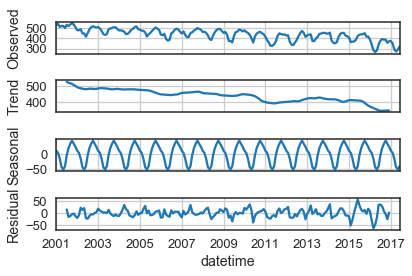

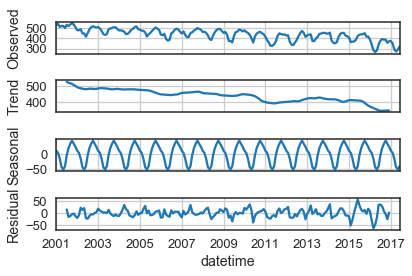

In [391]:
sd.plot()

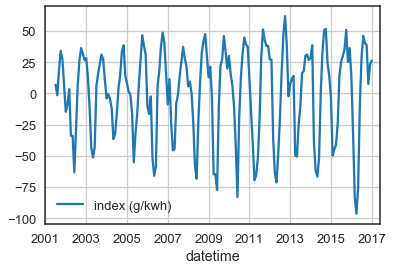

In [395]:
(wecc - wecc.rolling(12, center=True).mean()).plot()

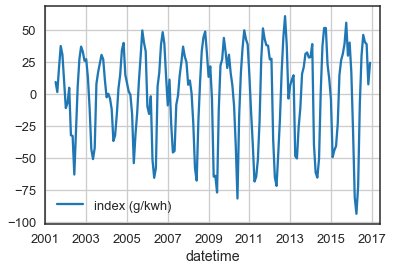

In [347]:
(wecc - sd.trend).plot()

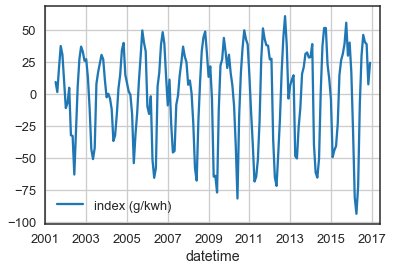

In [346]:
(sd.seasonal + sd.resid).plot()

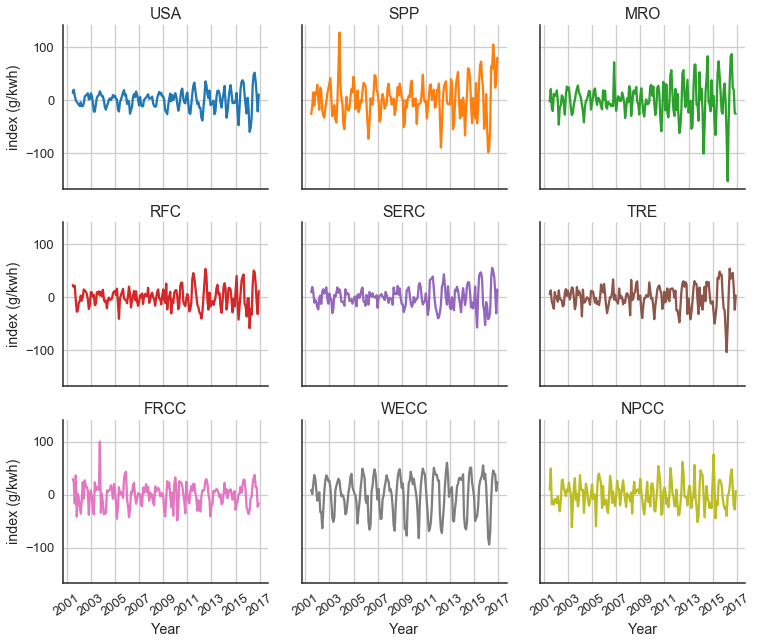

In [573]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

temp = index.copy()
temp.set_index('datetime', inplace=True)
# detrend_index.sort_index(inplace=True)

df_list = []
for nerc in order:
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - seasonal_decompose(temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']).trend)
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)
# detrend_index.set_index('datetime', append=True, inplace=True)
# detrend_index.sort_index(level='datetime', inplace=True)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

In [559]:
combined = index.copy()
combined.set_index(['nerc', 'datetime'], inplace=True)
df = detrend_index.reset_index(drop=True).set_index(['nerc', 'datetime'])
df.columns = ['detrend index']

In [561]:
combined = pd.concat([index.set_index(['nerc', 'datetime']), df])

In [562]:
combined.head()

change since 2005  detrend index  final co2 (kg)  \
nerc datetime                                                       
USA  2001-01-01           0.076326            NaN    2.149920e+11   
     2001-02-01           0.060812            NaN    1.803140e+11   
     2001-03-01           0.046964            NaN    1.891340e+11   
     2001-04-01           0.046860            NaN    1.748850e+11   
     2001-05-01           0.048337            NaN    1.892470e+11   

                 generation (mwh)  index (g/kwh)  index (lb/mwh)  month  \
nerc datetime                                                             
USA  2001-01-01       332493160.0     646.604591     1425.504481    1.0   
     2001-02-01       282940198.0     637.284923     1404.958340    2.0   
     2001-03-01       300706544.0     628.965732     1386.617853    3.0   
     2001-04-01       278078871.0     628.902838     1386.479197    4.0   
     2001-05-01       300491621.0     629.790069     1388.435187    5.0   

                 quarter    year  
nerc datetime                     
USA  2001-01-01      1.0  2001.0  
     2001-02-01      1.0  2001.0  
     2001-03-01      1.0  2001.0  
     2001-04-01      2.0  2001.0  
     2001-05-01      2.0  2001.0

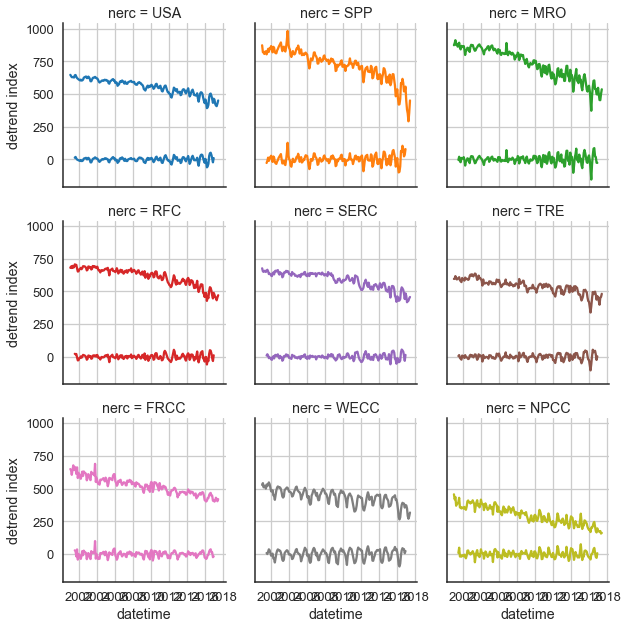

In [571]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
g = sns.FacetGrid(combined.reset_index(), col='nerc', hue='nerc', col_wrap=3, 
                  hue_order=order, col_order=order)
g.map(plt.plot, 'datetime', 'index (g/kwh)')
g.map(plt.plot, 'datetime', 'detrend index')

In [553]:
detrend_index.tail()

,index (g/kwh),nerc
datetime,,
2017-02-01,NaN,NPCC
2017-03-01,NaN,NPCC
2017-04-01,NaN,NPCC
2017-05-01,NaN,NPCC
2017-06-01,NaN,NPCC


### Percent gen figures

#### Color palette for fuel categories

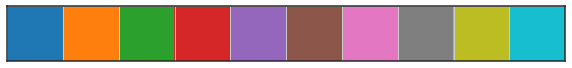

In [21]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

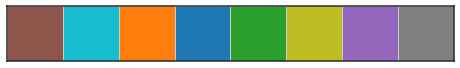

In [22]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

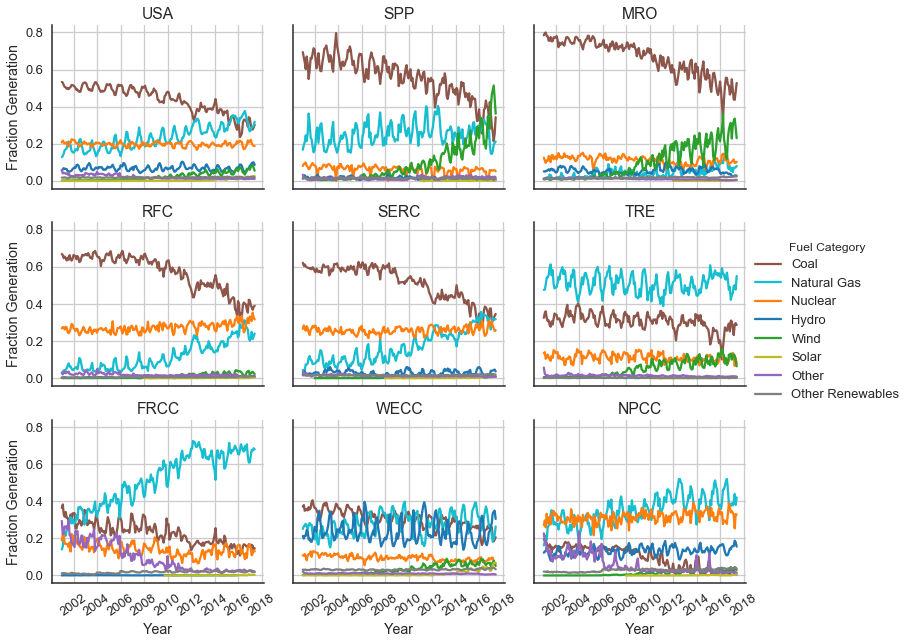

In [48]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette)

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='Fraction Generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, ax_labels='Year',
                  context='talk', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full.pdf')
plt.savefig(path, bbox_inches='tight')

## Figure of wind, nat gas, and coal

In [21]:
per_gen.dtypes

datetime               datetime64[ns]
fuel category                  object
Fraction Generation           float64
month                           int64
nerc                           object
year                            int64
dtype: object

In [82]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

,datetime,fuel category,Fraction Generation,month,nerc,year
2612,2005-01-01,Coal,0.753739,NaN,MRO,2005
2613,2005-02-01,Coal,0.766800,NaN,MRO,2005
2614,2005-03-01,Coal,0.780396,NaN,MRO,2005
2615,2005-04-01,Coal,0.774250,NaN,MRO,2005
2616,2005-05-01,Coal,0.762964,NaN,MRO,2005


In [22]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2016'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, 'Fraction Generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

In [23]:
temp_df.head()

,datetime,fuel category,Fraction Generation,month,nerc,year,timeframe,generation (mwh),generation
0,2005-01-01,Coal,0.753739,1,MRO,2005,2005-2008,1.552018e+07,11.698157
1,2005-01-01,Natural Gas,0.025970,1,MRO,2005,2005-2008,1.552018e+07,0.403064
2,2005-01-01,Wind,0.014663,1,MRO,2005,2005-2008,1.552018e+07,0.227579
3,2005-02-01,Coal,0.766800,2,MRO,2005,2005-2008,1.338076e+07,10.260365
4,2005-02-01,Natural Gas,0.024931,2,MRO,2005,2005-2008,1.338076e+07,0.333600


In [26]:
# a is the list of colors
a = fuel_palette[0:2]
a.append(fuel_palette[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


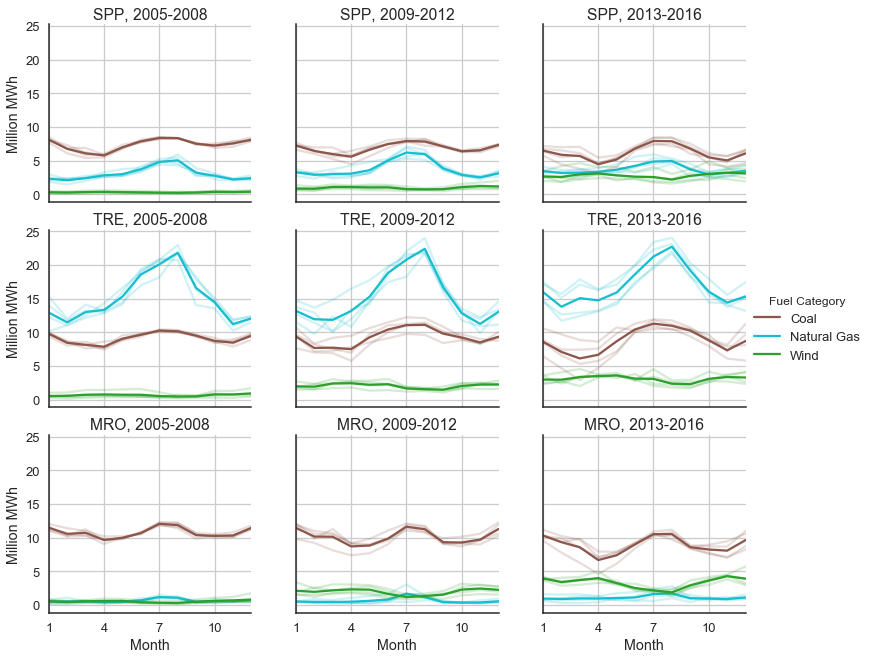

In [328]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2016']

with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.15)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures', 'Wind-Coal-NG variability tsplot.pdf')
plt.savefig(path, bbox_inches='tight')

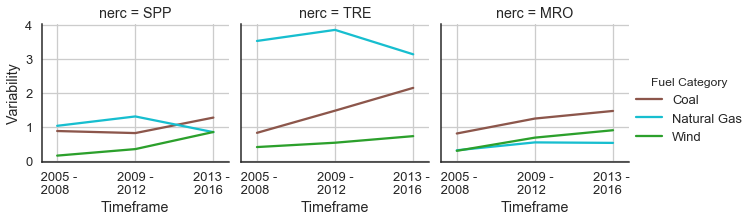

In [325]:
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2016': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
                   .std()
                   .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability')
axes = g.axes.flatten()
for ax in axes:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2016   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG variability.pdf')
plt.savefig(path, bbox_inches='tight')

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [101]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [48]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

In [49]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
-    2001-01-01      0                NaN    5.476076e+09       7185661.388   
     2001-02-01      1                NaN    4.349473e+09       6526739.453   
     2001-03-01      2                NaN    4.223575e+09       6304139.884   
     2001-04-01      3                NaN    4.544873e+09       6624660.323   
     2001-05-01      4                NaN    4.972656e+09       7045482.729   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
-    2001-01-01     762.083771             NaN      1      NaN  2001  
     2001-02-01     666.408193             NaN      2      NaN  2001  
     2001-03-01     669.968545             NaN      3      NaN  2001  
     2001-04-01     686.053817             NaN      4      NaN  2001  
     2001-05-01     705.793523             NaN      5      NaN  2001

In [ ]:
def seasonal_detrend()

In [451]:
df = index.copy()
df.set_index(['nerc', 'datetime'], inplace=True)
df.sort_index(inplace=True)

In [452]:
df.head()

change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                          
-    2001-01-01                NaN    5.476076e+09       7185661.388   
     2001-02-01                NaN    4.349473e+09       6526739.453   
     2001-03-01                NaN    4.223575e+09       6304139.884   
     2001-04-01                NaN    4.544873e+09       6624660.323   
     2001-05-01                NaN    4.972656e+09       7045482.729   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
-    2001-01-01     762.083771             NaN      1      NaN  2001  
     2001-02-01     666.408193             NaN      2      NaN  2001  
     2001-03-01     669.968545             NaN      3      NaN  2001  
     2001-04-01     686.053817             NaN      4      NaN  2001  
     2001-05-01     705.793523             NaN      5      NaN  2001

In [355]:
df.loc['WECC', 'index (g/kwh)'] - seasonal_decompose(df.loc['WECC', 'index (g/kwh)']).trend

datetime
2001-01-01          NaN
2001-02-01          NaN
2001-03-01          NaN
2001-04-01          NaN
2001-05-01          NaN
2001-06-01          NaN
2001-07-01     8.998388
2001-08-01     1.183566
2001-09-01    20.089510
2001-10-01    37.126504
2001-11-01    30.400553
2001-12-01     9.380467
2002-01-01   -11.327881
2002-02-01    -7.523121
2002-03-01     4.512235
2002-04-01   -32.596226
2002-05-01   -33.033481
2002-06-01   -63.212049
2002-07-01   -29.568194
2002-08-01     5.749889
2002-09-01    27.038169
2002-10-01    36.668630
2002-11-01    32.652769
2002-12-01    25.573039
2003-01-01    26.775681
2003-02-01    12.446076
2003-03-01   -11.173308
2003-04-01   -43.339921
2003-05-01   -51.157461
2003-06-01   -42.460923
                ...    
2015-01-01    -4.405837
2015-02-01   -49.629923
2015-03-01   -44.221366
2015-04-01   -41.021338
2015-05-01   -23.549898
2015-06-01    14.473650
2015-07-01    26.068646
2015-08-01    31.043330
2015-09-01    38.807924
2015-10-01    55.315347
2015-11

In [442]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [406]:
(df.loc[nerc]['index (g/kwh)'] - nerc_mov_avg)

nerc
SPP           NaN
SPP           NaN
SPP           NaN
SPP           NaN
SPP           NaN
SPP           NaN
SPP    -26.810163
SPP     -9.864131
SPP     14.439248
SPP     -8.288519
SPP     15.686013
SPP     11.821534
SPP     29.182165
SPP     -1.075210
SPP    -18.658070
SPP     24.204050
SPP     15.937120
SPP    -18.900209
SPP    -28.511818
SPP    -30.873730
SPP    -13.083949
SPP     -6.173915
SPP     12.148829
SPP     23.955171
SPP     32.594458
SPP     41.934758
SPP      5.367469
SPP    -27.797918
SPP    -14.240902
SPP     -9.224776
          ...    
SPP    -24.408514
SPP    -36.382688
SPP     29.174370
SPP    -46.479386
SPP    -23.813143
SPP     27.307971
SPP     63.158119
SPP     67.495620
SPP     32.342833
SPP     10.395638
SPP    -59.315262
SPP    -38.447351
SPP      8.071633
SPP    -56.597294
SPP    -99.663711
SPP    -95.839917
SPP    -51.307118
SPP     66.738037
SPP     55.728170
SPP    101.138308
SPP     75.904755
SPP     18.081950
SPP     32.288905
SPP     73.969411
SPP  

In [453]:
df = index.copy()
nercs = ['SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
df.set_index(['nerc', 'datetime'], inplace=True)
df_list = []
for nerc in nercs:
    nerc_mov_avg = df.loc[nerc]['index (g/kwh)'].rolling(12, center=True).mean()
    temp = (df.loc[nerc]['index (g/kwh)'] - nerc_mov_avg)
    temp = temp.reset_index()
    temp['nerc'] = nerc
    df_list.append(temp)
df = pd.concat(df_list)

In [454]:
df.head()

,datetime,index (g/kwh),nerc
0,2001-01-01,NaN,SPP
1,2001-02-01,NaN,SPP
2,2001-03-01,NaN,SPP
3,2001-04-01,NaN,SPP
4,2001-05-01,NaN,SPP


In [477]:
def add_count(df):
    nercs = df['variable'].unique()
    for nerc in nercs:
        df.loc[df['variable'] == nerc, 'count'] = range(len(df.loc[df['variable'] == nerc]))

In [547]:
def rolling_corr_plot(index, region_pairs, window, center=True,
                      order=None, legend_order=None,
                      x_lim=(2001, 2017), detrend_series=False,
                      diff=False, annual=False, seasonal=False, shift=1):
    
    df = index.copy()
    
    df.reset_index(inplace=True)
    nercs = df['nerc'].unique()
    df.set_index(['nerc', 'datetime'], inplace=True)
    df.sort_index(inplace=True)
    
    df_list = []
    if detrend_series:
        for nerc in nercs:
            if diff:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(df.loc[idx[nerc, :], 'index (g/kwh)'], shift)
#                 df.loc[idx[nerc, :], 'count'] = range(len(df.loc[idx[nerc, :], :]))
            if annual:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = annual_detrend(df.loc[idx[nerc, :]])
#                 df.loc[idx[nerc, :], 'count'] = range(len(df.loc[idx[nerc, :], :]))
#                 return df
            if seasonal:
                trend = df.loc[nerc, 'index (g/kwh)'].rolling(12, center=True).mean()
                detr = df.loc[nerc, 'index (g/kwh)'] - trend
                detr = pd.DataFrame(detr)
                detr['nerc'] = nerc
#                 df.loc[idx[nerc, :], 'count'] = range(len(df.loc[idx[nerc, :], :]))
                df_list.append(detr)

            else:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(df.loc[idx[nerc, :], 'index (g/kwh)'])
        
        if seasonal:
            df = pd.concat(df_list)
            df.reset_index(inplace=True)
#             return df
            df.set_index(['nerc', 'datetime'], inplace=True)
    df.dropna(inplace=True)
#     return df
    corr_df = pd.concat([(df.loc[regions[0]]['index (g/kwh)']
                         .rolling(window, center=center)
                         .corr(df.loc[regions[1]]['index (g/kwh)']))
                         for regions in region_pairs], axis=1)
    cols = ['{} | {}'.format(regions[0], regions[1]) for regions in region_pairs]
    corr_df.columns = cols
    
    
    
    corr_tidy = pd.melt(corr_df.reset_index(), id_vars=['datetime'],
                        value_name='Correlation')
    corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
    corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]

    #datetime_s is seconds since epoch - regplot won't take datetime objects
    corr_tidy['datetime_s'] = corr_tidy['datetime'].astype(int)
    
    add_count(corr_tidy)
#     corr_tidy['count'] = corr_tidy['datetime_s'] - corr_tidy['datetime_s'].max()
    
    if not order:
        order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
        
    if not legend_order:
        legend_order = ['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC']
    legend_len = len(legend_order)
    
    g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.2,
                      hue='region2', palette='tab10', size=2.5,
                      hue_order=legend_order)
    g.map(sns.regplot, 'count', 'Correlation', marker='.',
          truncate=True, scatter_kws={'s': 0})

    # regplot only does a scatter - add plt.plot for the lines
    g.map(plt.plot, 'count', 'Correlation')


    # Create custom patch lines for the legend - the default dots were small
    plot_colors = sns.color_palette('tab10', legend_len)
    legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
    legend_data = dict(zip(legend_order, legend_patches))
    g.add_legend(legend_data=legend_data, title='Second Region')

    # Need to do all x-axis work in seconds since epoch, since that's what I'm
    # passing through to regplot.
    axes = g.axes.flatten()

    # Grid lines at the start of each odd year from 2001-17
    years = range(2004, 2017, 2)#range(x_lim[0], x_lim[1] + 1, 2)
    distance = 24 # months in 2 years
    x_ticks = [(x * distance) + 6 for x in range(1, 8)]
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         oldticks = ax.get_
#         newticks = 
        ax.set_xticks(x_ticks)
        

    # Year for the ticklabels
    g.set_xticklabels(years, rotation=35)
    g.set_xlabels('Year')
    
#     return corr_tidy

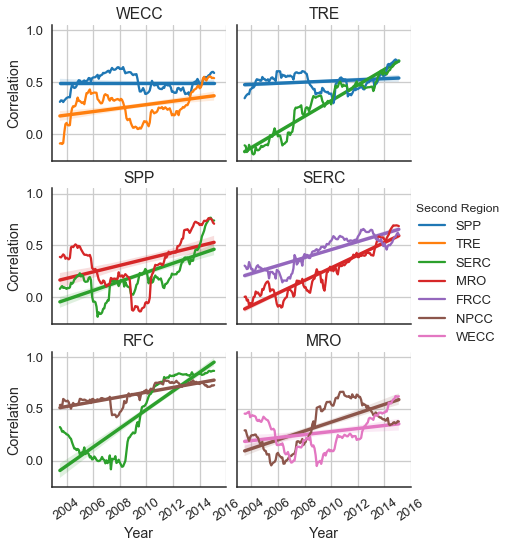

In [550]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48, x_lim=(2002, 2016),
                       detrend_series=True, seasonal=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
plt.savefig(path, bbox_inches='tight')

In [527]:
ticks, lim

(array([   0.,   50.,  100.,  150.,  200.]),
 (17.049999999999997, 169.94999999999999))

In [486]:
186 / 8

23.25

In [518]:
dates = df.loc[df['variable'] == 'WECC | SPP', 'datetime']

In [531]:
dates.iloc[ticks[:-1]]

0     2001-07-01
50    2005-09-01
100   2009-11-01
150   2014-01-01
Name: datetime, dtype: datetime64[ns]

In [532]:
df

,datetime,variable,Correlation,region1,region2,datetime_s,count
0,2001-07-01,WECC | SPP,NaN,WECC,SPP,993945600000000000,0.0
1,2001-08-01,WECC | SPP,NaN,WECC,SPP,996624000000000000,1.0
2,2001-09-01,WECC | SPP,NaN,WECC,SPP,999302400000000000,2.0
3,2001-10-01,WECC | SPP,NaN,WECC,SPP,1001894400000000000,3.0
4,2001-11-01,WECC | SPP,NaN,WECC,SPP,1004572800000000000,4.0
5,2001-12-01,WECC | SPP,NaN,WECC,SPP,1007164800000000000,5.0
6,2002-01-01,WECC | SPP,NaN,WECC,SPP,1009843200000000000,6.0
7,2002-02-01,WECC | SPP,NaN,WECC,SPP,1012521600000000000,7.0
8,2002-03-01,WECC | SPP,NaN,WECC,SPP,1014940800000000000,8.0
9,2002-04-01,WECC | SPP,NaN,WECC,SPP,1017619200000000000,9.0


### Compare different rolling windows (12, 24, 36, 48, and 72 months)

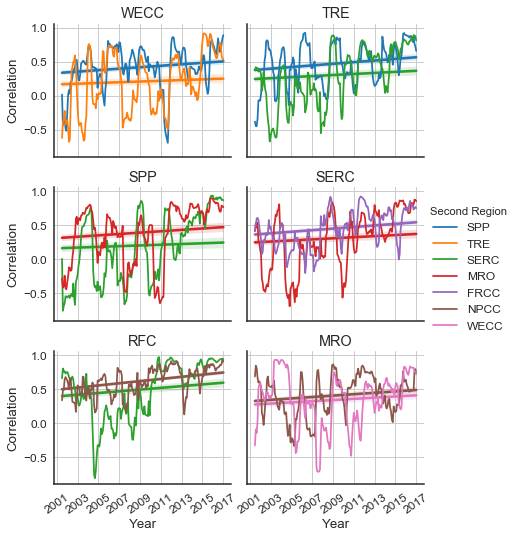

In [124]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12)

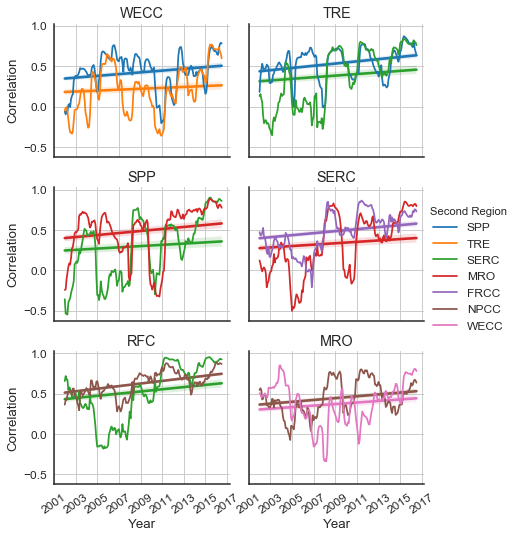

In [125]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24)

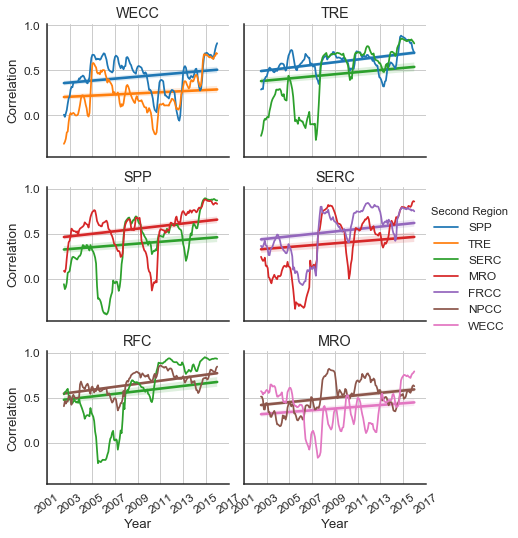

In [126]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36)

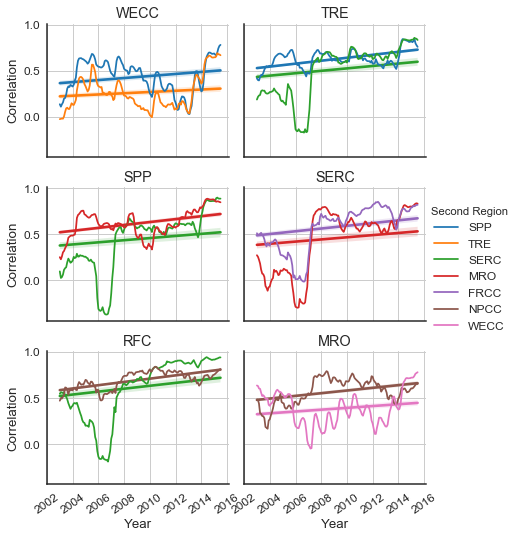

In [137]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016))
path = join(cwd, '..', 'Figures', 'Rolling correlation - 48m centered.pdf')
plt.savefig(path, bbox_inches='tight')

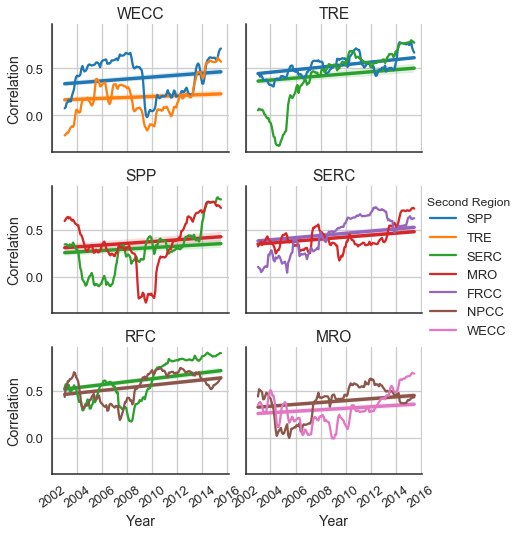

In [181]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016), detrend_series=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

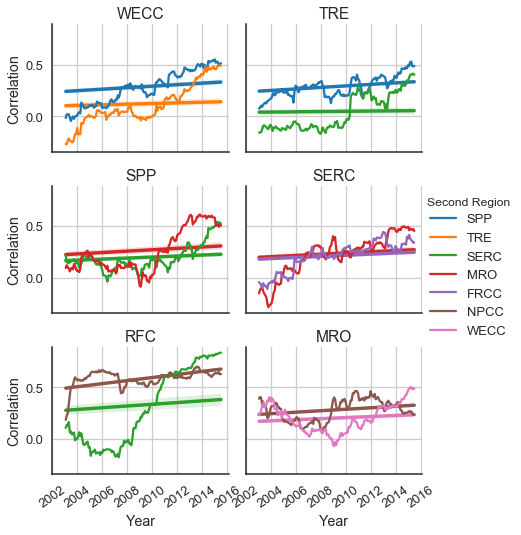

In [183]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016), detrend_series=True, diff=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - first diff detrend 48m centered.pdf')
plt.savefig(path, bbox_inches='tight')

In [267]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016), detrend_series=True, annual=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - first diff detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

In [497]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2003, 2016), detrend_series=True, diff=True,
                 shift=12)
path = join(cwd, '..', 'Figures', 'Rolling correlation - first diff detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

ValueError: num must be 1 <= num <= 0, not 1

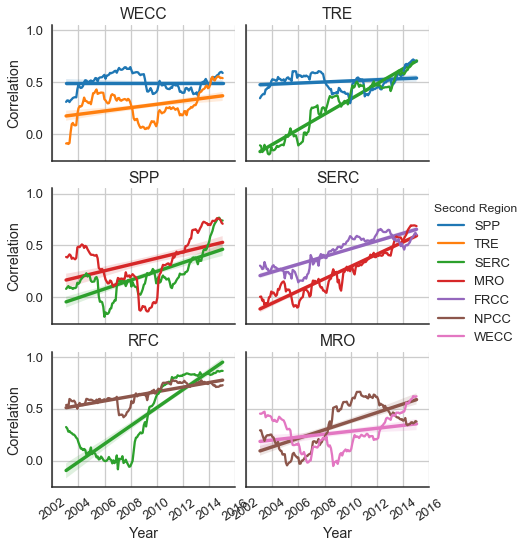

In [507]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                  x_lim=(2002, 2016), detrend_series=True, seasonal=True,
                 shift=12)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

In [491]:
df

,datetime,variable,Correlation,region1,region2,datetime_s,count
0,2001-07-01,WECC | SPP,NaN,WECC,SPP,993945600000000000,0.0
1,2001-08-01,WECC | SPP,NaN,WECC,SPP,996624000000000000,1.0
2,2001-09-01,WECC | SPP,NaN,WECC,SPP,999302400000000000,2.0
3,2001-10-01,WECC | SPP,NaN,WECC,SPP,1001894400000000000,3.0
4,2001-11-01,WECC | SPP,NaN,WECC,SPP,1004572800000000000,4.0
5,2001-12-01,WECC | SPP,NaN,WECC,SPP,1007164800000000000,5.0
6,2002-01-01,WECC | SPP,NaN,WECC,SPP,1009843200000000000,6.0
7,2002-02-01,WECC | SPP,NaN,WECC,SPP,1012521600000000000,7.0
8,2002-03-01,WECC | SPP,NaN,WECC,SPP,1014940800000000000,8.0
9,2002-04-01,WECC | SPP,NaN,WECC,SPP,1017619200000000000,9.0


In [421]:
df.set_index(['region1', 'region2'], inplace=True)
df[]

In [428]:
df.loc[idx['TRE', 'SERC'], 'count'] = range(187)
df.loc[idx['TRE', 'SERC'], :]

/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


datetime    variable  Correlation           datetime_s  \
region1 region2                                                            
TRE     SERC    2001-07-01  TRE | SERC          NaN   993945600000000000   
        SERC    2001-08-01  TRE | SERC          NaN   996624000000000000   
        SERC    2001-09-01  TRE | SERC          NaN   999302400000000000   
        SERC    2001-10-01  TRE | SERC          NaN  1001894400000000000   
        SERC    2001-11-01  TRE | SERC          NaN  1004572800000000000   
        SERC    2001-12-01  TRE | SERC          NaN  1007164800000000000   
        SERC    2002-01-01  TRE | SERC          NaN  1009843200000000000   
        SERC    2002-02-01  TRE | SERC          NaN  1012521600000000000   
        SERC    2002-03-01  TRE | SERC          NaN  1014940800000000000   
        SERC    2002-04-01  TRE | SERC          NaN  1017619200000000000   
        SERC    2002-05-01  TRE | SERC          NaN  1020211200000000000   
        SERC    2002-06-01  TRE | SERC          NaN  1022889600000000000   
        SERC    2002-07-01  TRE | SERC          NaN  1025481600000000000   
        SERC    2002-08-01  TRE | SERC          NaN  1028160000000000000   
        SERC    2002-09-01  TRE | SERC          NaN  1030838400000000000   
        SERC    2002-10-01  TRE | SERC          NaN  1033430400000000000   
        SERC    2002-11-01  TRE | SERC          NaN  1036108800000000000   
        SERC    2002-12-01  TRE | SERC          NaN  1038700800000000000   
        SERC    2003-01-01  TRE | SERC          NaN  1041379200000000000   
        SERC    2003-02-01  TRE | SERC          NaN  1044057600000000000   
        SERC    2003-03-01  TRE | SERC          NaN  1046476800000000000   
        SERC    2003-04-01  TRE | SERC          NaN  1049155200000000000   
        SERC    2003-05-01  TRE | SERC          NaN  1051747200000000000   
        SERC    2003-06-01  TRE | SERC          NaN  1054425600000000000   
        SERC    2003-07-01  TRE | SERC    -0.111101  1057017600000000000   
        SERC    2003-08-01  TRE | SERC    -0.119282  1059696000000000000   
        SERC    2003-09-01  TRE | SERC    -0.175841  1062374400000000000   
        SERC    2003-10-01  TRE | SERC    -0.164137  1064966400000000000   
        SERC    2003-11-01  TRE | SERC    -0.106034  1067644800000000000   
        SERC    2003-12-01  TRE | SERC    -0.141057  1070236800000000000   
...                    ...         ...          ...                  ...   
        SERC    2014-08-01  TRE | SERC     0.644586  1406851200000000000   
        SERC    2014-09-01  TRE | SERC     0.656116  1409529600000000000   
        SERC    2014-10-01  TRE | SERC     0.674458  1412121600000000000   
        SERC    2014-11-01  TRE | SERC     0.692718  1414800000000000000   
        SERC    2014-12-01  TRE | SERC     0.692642  1417392000000000000   
        SERC    2015-01-01  TRE | SERC     0.697129  1420070400000000000   
        SERC    2015-02-01  TRE | SERC     0.700830  1422748800000000000   
        SERC    2015-03-01  TRE | SERC          NaN  1425168000000000000   
        SERC    2015-04-01  TRE | SERC          NaN  1427846400000000000   
        SERC    2015-05-01  TRE | SERC          NaN  1430438400000000000   
        SERC    2015-06-01  TRE | SERC          NaN  1433116800000000000   
        SERC    2015-07-01  TRE | SERC          NaN  1435708800000000000   
        SERC    2015-08-01  TRE | SERC          NaN  1438387200000000000   
        SERC    2015-09-01  TRE | SERC          NaN  1441065600000000000   
        SERC    2015-10-01  TRE | SERC          NaN  1443657600000000000   
        SERC    2015-11-01  TRE | SERC          NaN  1446336000000000000   
        SERC    2015-12-01  TRE | SERC          NaN  1448928000000000000   
        SERC    2016-01-01  TRE | SERC          NaN  1451606400000000000   
        SERC    2016-02-01  TRE | SERC          NaN  1454284800000000000   
        SERC    2016-03-01  TRE | SERC          NaN  1456790400000

/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


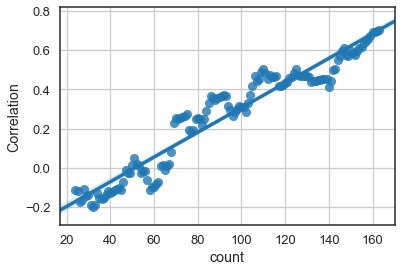

In [429]:
sns.regplot('count', 'Correlation', data=df.loc[idx['TRE', 'SERC'], :].dropna())

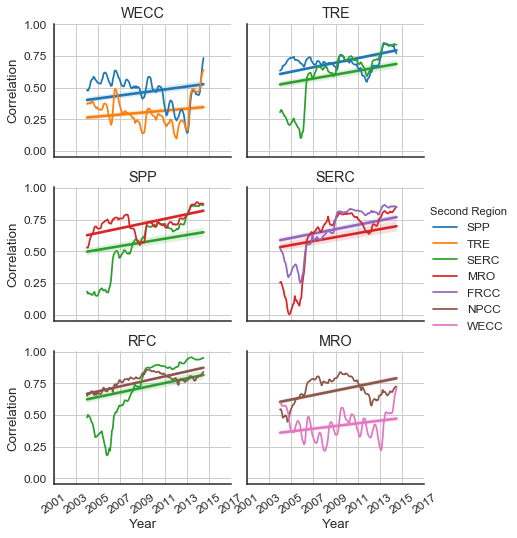

In [132]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72)

/Users/greg/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


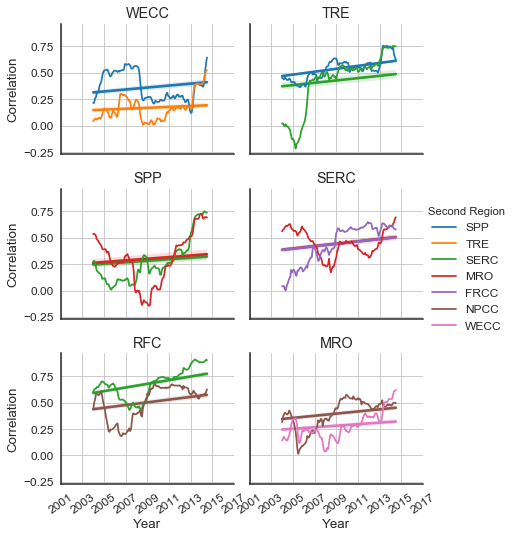

In [153]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72, detrend_series=True)

In [138]:
corr_df = pd.concat([(detrend(index.loc[regions[0]]['index (g/kwh)'])
                     .rolling(24, center=True)
                     .corr(detrend(index.loc[regions[1]]['index (g/kwh)'])))
                     for regions in region_pairs], axis=1)
cols = ['{} | {}'.format(regions[0], regions[1]) for regions in region_pairs]
corr_df.columns = cols

In [139]:
corr_df.tail()

,WECC | SPP,WECC | TRE,TRE | SPP,TRE | SERC,SPP | MRO,SPP | SERC,SERC | FRCC,SERC | MRO,RFC | SERC,RFC | NPCC,MRO | NPCC,MRO | WECC
datetime,,,,,,,,,,,,
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
corr_tidy = pd.melt(corr_df.reset_index(), id_vars='datetime',
                    value_name='Correlation')
corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]

#datetime_s is seconds since epoch - regplot won't take datetime objects
corr_tidy['datetime_s'] = corr_tidy['datetime'].astype(int)
corr_tidy.tail()

,datetime,variable,Correlation,region1,region2,datetime_s
2371,2017-02-01,MRO | WECC,NaN,MRO,WECC,1485907200000000000
2372,2017-03-01,MRO | WECC,NaN,MRO,WECC,1488326400000000000
2373,2017-04-01,MRO | WECC,NaN,MRO,WECC,1491004800000000000
2374,2017-05-01,MRO | WECC,NaN,MRO,WECC,1493596800000000000
2375,2017-06-01,MRO | WECC,NaN,MRO,WECC,1496275200000000000


In [141]:
corr_tidy.region1.unique(), corr_tidy.region2.unique()

(array(['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO'], dtype=object),
 array(['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC'], dtype=object))

In [142]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

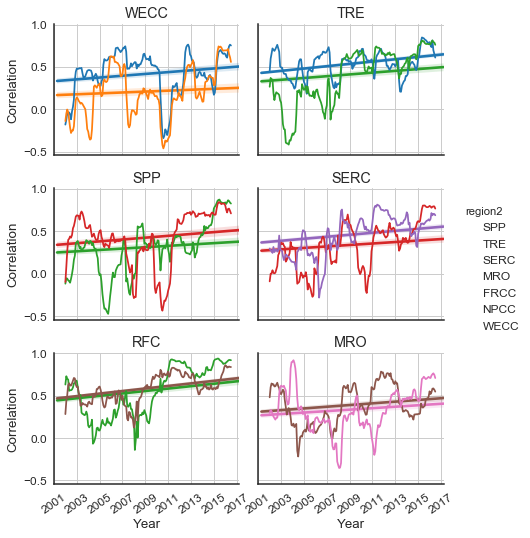

In [144]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0})

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation').add_legend()


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
# g.add_legend(legend_data=legend_data, title='Second Region')
# g.add_legend()

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

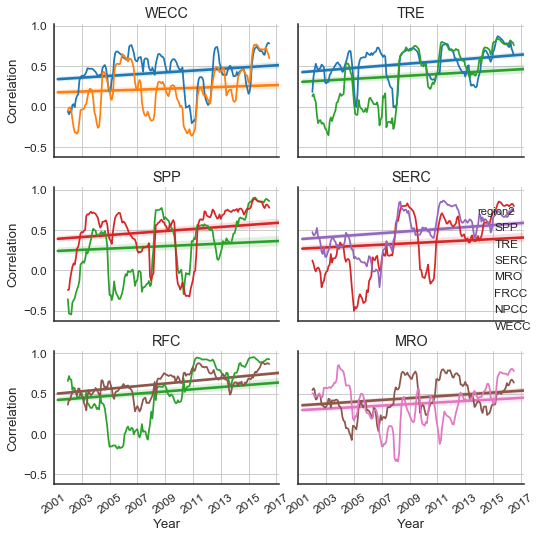

In [113]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0}).add_legend()

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
# g.add_legend(legend_data=legend_data, title='Second Region')
# g.add_legend()

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

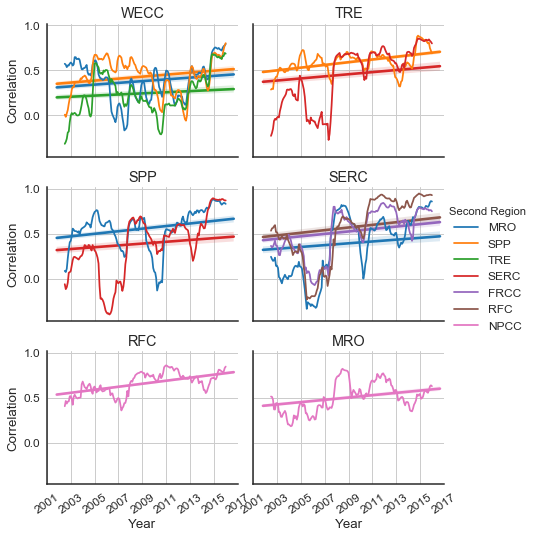

In [67]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0})

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
g.add_legend(legend_data=legend_data, title='Second Region')

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

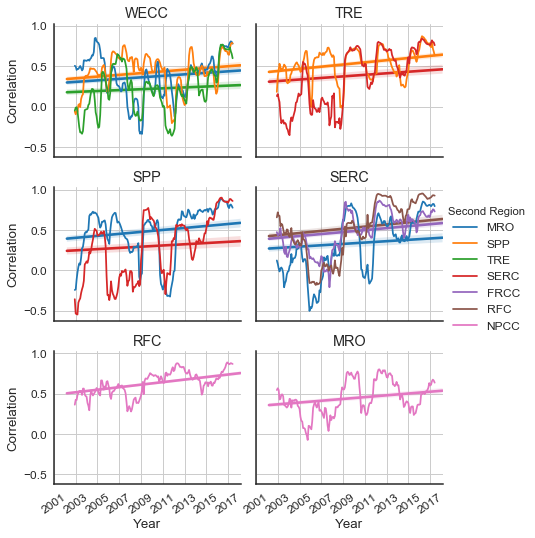

In [55]:
order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                  hue='region2', palette='tab10', size=2.5)

# regplot for the regression line, but make size of points 0
g.map(sns.regplot, 'datetime_s', 'Correlation', marker='.',
      scatter_kws={'s': 0})

# regplot only does a scatter - add plt.plot for the lines
g.map(plt.plot, 'datetime_s', 'Correlation')


# Create custom patch lines for the legend - the default dots were small
plot_colors = sns.color_palette('tab10', 7)
legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
legend_order = ['MRO', 'SPP', 'TRE', 'SERC', 'FRCC', 'RFC', 'NPCC']
legend_data = dict(zip(legend_order, legend_patches))
g.add_legend(legend_data=legend_data, title='Second Region')

# Need to do all x-axis work in seconds since epoch, since that's what I'm
# passing through to regplot.
axes = g.axes.flatten()

# Grid lines at the start of each odd year from 2001-17
x_ticks = pd.to_datetime([str(x) for x in range(2001, 2018, 2)]).astype(int)
for ax, title in zip(axes, order):
    ax.set_title(title)
    ax.set_xticks(x_ticks)

# Year for the ticklabels
g.set_xticklabels(pd.to_datetime(x_ticks).year, rotation=35)
g.set_xlabels('Year')

path = join(cwd, '..', 'Figures', 'Rolling correlation.pdf')
# plt.savefig(path, bbox_inches='tight')

## Changes in CO₂ intensity for each NERC region

In [268]:
index.head()

,change since 2005,datetime,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,nerc,quarter,year
0,0.076326,2001-01-01,2.149920e+11,332493160.0,646.604591,1425.504481,1,USA,1.0,2001
1,0.060812,2001-02-01,1.803140e+11,282940198.0,637.284923,1404.958340,2,USA,1.0,2001
2,0.046964,2001-03-01,1.891340e+11,300706544.0,628.965732,1386.617853,3,USA,1.0,2001
3,0.046860,2001-04-01,1.748850e+11,278078871.0,628.902838,1386.479197,4,USA,2.0,2001
4,0.048337,2001-05-01,1.892470e+11,300491621.0,629.790069,1388.435187,5,USA,2.0,2001


In [281]:
annual_index = index.groupby(['year', 'nerc']).sum()
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.sort_index(inplace=True)

In [576]:
annual_index.head()

change since 2005  final co2 (kg)  generation (mwh)  index (g/kwh)  \
year nerc                                                                       
2001 -                   NaN    6.282915e+10      8.687608e+07     723.204245   
     FRCC                NaN    1.133053e+11      1.769298e+08     640.396938   
     MRO                 NaN    1.401621e+11      1.605119e+08     873.218911   
     NPCC                NaN    9.502271e+10      2.414221e+08     393.595809   
     RFC                 NaN    5.698209e+11      8.331239e+08     683.956931   

           index (lb/mwh)  month  quarter  
year nerc                                  
2001 -                NaN     78      NaN  
     FRCC             NaN     78      NaN  
     MRO              NaN     78      NaN  
     NPCC             NaN     78      NaN  
     RFC              NaN     78      NaN

In [577]:
annual_index.loc[idx[:, 'USA'], :]

,,change since 2005,final co2 (kg),generation (mwh),index (g/kwh),index (lb/mwh),month,quarter
year,nerc,,,,,,,
2001,USA,0.597795,2.358945e+12,3.736644e+09,631.300499,16684.737740,78,30.0
2002,USA,0.322061,2.382179e+12,3.858452e+09,617.392375,16319.549907,78,30.0
2003,USA,0.376829,2.407509e+12,3.883185e+09,619.983049,16392.085946,78,30.0
2004,USA,0.029118,2.391809e+12,3.970555e+09,602.386528,15931.571617,78,30.0
2005,USA,-0.006476,2.436302e+12,4.055423e+09,600.751673,15884.430996,78,30.0
2006,USA,-0.276046,2.387001e+12,4.064702e+09,587.251136,15527.406603,78,30.0
2007,USA,-0.223557,2.451740e+12,4.156745e+09,589.822123,15596.924419,78,30.0
2008,USA,-0.379183,2.397134e+12,4.119388e+09,581.915115,15390.810992,78,30.0
2009,USA,-0.985714,2.180357e+12,3.950331e+09,551.942873,14587.510098,78,30.0


In [574]:
(((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values(),
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values() / 15)

(nerc
 -       116.956816
 TRE     148.128487
 SERC    173.061628
 WECC    175.095311
 USA     175.454892
 NPCC    191.693722
 RFC     198.731821
 FRCC    206.269158
 SPP     301.162515
 MRO     349.466373
 Name: index (g/kwh), dtype: float64, nerc
 -        7.797121
 TRE      9.875232
 SERC    11.537442
 WECC    11.673021
 USA     11.696993
 NPCC    12.779581
 RFC     13.248788
 FRCC    13.751277
 SPP     20.077501
 MRO     23.297758
 Name: index (g/kwh), dtype: float64)

In [298]:
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])
 / annual_index.loc[2001, 'index (g/kwh)']).sort_values()

nerc
-       0.161720
TRE     0.248578
SERC    0.265376
USA     0.277926
RFC     0.290562
FRCC    0.322096
WECC    0.333365
SPP     0.363138
MRO     0.400205
NPCC    0.487032
Name: index (g/kwh), dtype: float64